In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras_spectral_norm_layers import DenseSN, ConvSN1D, ConvSN2D, ConvSN3D, EmbeddingSN

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import subprocess


Using TensorFlow backend.


In [2]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class BatchNormalization(Layer):
    """Batch normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(BatchNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(BatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [5]:
#Load APA plasmid data (random mpra)
plasmid_dict = pickle.load(open('../../../../aparent/apa_plasmid_data.pickle', 'rb'))

plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)))


len(plasmid_df) = 3810974


In [6]:
#Filter data
kept_libraries = [22]

min_count = 50#40#50
min_usage = 0.95#0.9

if kept_libraries is not None :
    keep_index = np.nonzero(plasmid_df.library_index.isin(kept_libraries))[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_count is not None :
    keep_index = np.nonzero(plasmid_df.total_count >= min_count)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_usage is not None :
    
    prox_c = np.ravel(plasmid_cuts[:, 180+70+6:180+70+6+35].sum(axis=-1))
    total_c = np.ravel(plasmid_cuts[:, 180:180+205].sum(axis=-1)) + np.ravel(plasmid_cuts[:, -1].todense())
    
    keep_index = np.nonzero(prox_c / total_c >= min_usage)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (filtered)")


len(plasmid_df) = 49901 (filtered)


In [3]:
#Store cached filtered dataframe
#pickle.dump({'plasmid_df' : plasmid_df, 'plasmid_cuts' : plasmid_cuts}, open('apa_simple_cached_set_small.pickle', 'wb'))

#Load cached dataframe
cached_dict = pickle.load(open('apa_simple_cached_set_small.pickle', 'rb'))
plasmid_df = cached_dict['plasmid_df']
plasmid_cuts = cached_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (loaded)")


len(plasmid_df) = 49901 (loaded)


In [4]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : plasmid_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('padded_seq', start_pos=250 - 125, end_pos=250 + 6 + 125),
                'encoder' : iso.OneHotEncoder(seq_length=256),
                'dim' : (1, 1, 256, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'dummy_output',
                'source_type' : 'zeros',
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}


Training set size = 44911
Validation set size = 2495
Test set size = 2495


In [5]:

def make_gen_resblock(n_channels=64, window_size=3, stride=1, dilation=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x))
    
    deconv_0 = Conv2DTranspose(n_channels, (1, window_size), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_deconv_0')

    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_deconv_0 = Conv2DTranspose(n_channels, (1, 1), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_deconv_0')
    
    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor, training=True) :
        
        batch_norm_0_out = batch_norm_0(input_tensor, training=training)
        relu_0_out = relu_0(batch_norm_0_out)
        deconv_0_out = deconv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(deconv_0_out, training=training)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)
        
        skip_deconv_0_out = skip_deconv_0(input_tensor)

        skip_1_out = skip_1([conv_1_out, skip_deconv_0_out])
        
        return skip_1_out

    return _resblock_func

#GAN Generator Model definition
def load_generator_resnet(batch_size, seq_length=256) :

    #Generator network parameters
    latent_size = 100
    n_out_channels = 4
    window_size = 3
    
    strides = [2, 2, 2, 2, 2, 1]
    dilations = [1, 1, 1, 1, 1, 1]
    channels = [384, 256, 128, 64, 32, 32]
    initial_length = 8
    n_resblocks = len(strides)

    #Policy network definition
    policy_dense_0 = Dense(initial_length * channels[0], activation='linear', kernel_initializer='glorot_normal', name='policy_generator_dense_0')
    policy_dense_0_reshape = Reshape((1, initial_length, channels[0]))
    
    curr_length = initial_length
    
    class_concats = []
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_gen_resblock(n_channels=channels[layer_ix], window_size=window_size, stride=strides[layer_ix], dilation=dilations[layer_ix], group_ix=0, layer_ix=layer_ix))
    
    #final_batch_norm = BatchNormalization(name='policy_generator_final_batch_norm')
    #final_relu = Lambda(lambda x: K.relu(x))
    final_conv = Conv2D(n_out_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input, training=True) :
        
        policy_dense_0_out = policy_dense_0_reshape(policy_dense_0(seed_input))
        
        #Connect group of res blocks
        output_tensor = policy_dense_0_out

        #Res block group 0
        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor, training=training)

        #Final conv out
        #final_batch_norm_out = final_batch_norm(output_tensor, training=training)
        #final_relu_out = final_relu(final_batch_norm_out)
        final_conv_out = final_conv(output_tensor)#final_conv(final_relu_out)
        
        return final_conv_out

    return _generator_func


In [8]:

def make_disc_resblock_pooled(n_channels=64, window_size=3, dilation=1, drop_rate=0.0, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_0 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_0')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_1 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_1')
    
    pool_1 = AveragePooling2D(pool_size=(1, 2))
    
    drop_1 = Dropout(drop_rate, name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_drop_1')
    
    skip_conv_0 = ConvSN2D(n_channels, (1, 1), dilation_rate=(1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_snconv_0')
    
    skip_pool_0 = AveragePooling2D(pool_size=(1, 2))

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')
    
    #Execute res block
    def _resblock_func(input_tensor) :
        
        relu_0_out = relu_0(input_tensor)
        conv_0_out = conv_0(relu_0_out)

        relu_1_out = relu_1(conv_0_out)
        conv_1_out = conv_1(relu_1_out)
        pool_1_out = pool_1(conv_1_out)
        if drop_rate > 0.0 :
            pool_1_out = drop_1(pool_1_out, training=True)
        
        skip_conv_0_out = skip_conv_0(input_tensor)
        skip_pool_0_out = skip_pool_0(skip_conv_0_out)

        skip_1_out = skip_1([pool_1_out, skip_pool_0_out])
        
        return skip_1_out

    return _resblock_func

def make_disc_resblock(n_channels=64, window_size=3, dilation=1, drop_rate=0.0, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_0 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_0')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_1 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_1')
    
    drop_1 = Dropout(drop_rate, name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_drop_1')
    
    skip_conv_0 = ConvSN2D(n_channels, (1, 1), dilation_rate=(1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_snconv_0')
    
    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')
    
    #Execute res block
    def _resblock_func(input_tensor) :
        
        relu_0_out = relu_0(input_tensor)
        conv_0_out = conv_0(relu_0_out)

        relu_1_out = relu_1(conv_0_out)
        conv_1_out = conv_1(relu_1_out)
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1_out, training=True)
        
        skip_conv_0_out = skip_conv_0(input_tensor)

        skip_1_out = skip_1([conv_1_out, skip_conv_0_out])
        
        return skip_1_out

    return _resblock_func

def minibatch_stddev_layer(x, group_size=4) :
    group_size = tf.minimum(group_size, tf.shape(x)[0])  # Minibatch must be divisible by (or smaller than) group_size.
    s = x.shape  # [NCHW]  Input shape.
    y = tf.reshape(x, [group_size, -1, s[1], s[2], s[3]])  # [GMHWC] Split minibatch into M groups of size G.
    y = tf.cast(y, tf.float32)  # [GMHWC] Cast to FP32.
    y -= tf.reduce_mean(y, axis=0, keepdims=True)  # [GMCHW] Subtract mean over group.
    y = tf.reduce_mean(tf.square(y), axis=0)  # [MCHW]  Calc variance over group.
    y = tf.sqrt(y + 1e-8)  # [MCHW]  Calc stddev over group.
    
    y = tf.reduce_mean(y, axis=3, keepdims=True)  # [M111]  Take average over fmaps.
    y = tf.cast(y, x.dtype)  # [M111]  Cast back to original data type.
    y = tf.tile(y, [group_size, 1, 1, 1])  # [NHW1]  Replicate over group.

    return tf.concat([x, y], axis=3)  # [NHWC]  Append as new fmap.

#GAN Discriminator Model definition
def load_discriminator_resnet(batch_size, seq_length=256) :

    downsamples = [False, True, True, True]
    dilations = [1, 1, 1, 1]
    channels = [64, 64, 128, 256]
    window_sizes = [7, 7, 3, 3]
    drop_outs = [0.0, 0.0, 0.0, 0.0]
    
    n_resblocks = len(dilations)

    #policy_conv_0 = Conv2D(channels[0], (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        if downsamples[layer_ix] :
            resblocks.append(make_disc_resblock_pooled(n_channels=channels[layer_ix], window_size=window_sizes[layer_ix], dilation=dilations[layer_ix], drop_rate=drop_outs[layer_ix], group_ix=0, layer_ix=layer_ix))
        else :
            resblocks.append(make_disc_resblock(n_channels=channels[layer_ix], window_size=window_sizes[layer_ix], dilation=dilations[layer_ix], drop_rate=drop_outs[layer_ix], group_ix=0, layer_ix=layer_ix))
    
    #last_block_relu = Lambda(lambda x: K.relu(x, alpha=0.3))
    last_block_stdev = Lambda(lambda x: minibatch_stddev_layer(x, group_size=4))
    last_block_conv = ConvSN2D(channels[-1], (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_last_block_conv')
    
    real_flatten = Flatten()
    real_score = DenseSN(1, activation='linear', name='policy_discriminator_real_score')
    
    def _discriminator_func(seq_input) :
        
        #policy_conv_0_out = policy_conv_0(seq_input)
        
        #Connect group of res blocks
        output_tensor = seq_input#policy_conv_0_out

        #Res block group 0
        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor)

        #Append Stdev features
        output_tensor = last_block_stdev(output_tensor)
        
        #Last res block extr conv
        output_tensor = last_block_conv(output_tensor)
        
        #Final dense out
        real_score_out = real_score(real_flatten(output_tensor))

        return real_score_out

    return _discriminator_func


In [9]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]


KeyError: "Registering two gradient with name 'STMul'! (Previous registration was in <module> /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3)"

In [10]:

#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_only(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def sample_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def max_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))


#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates) :

    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False


#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max') :

    use_samples = True
    if n_samples is None :
        use_samples = False
        n_samples = 1

    
    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = sample_pwm
    if validation_sample_mode == 'sample' :
        sample_func = sample_pwm_only
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([raw_logits, onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        sampled_pwm = None
        
        #Optionally tile each PWM to sample from and create sample axis
        if use_samples :
            pwm_logits_upsampled = upsampling_layer(pwm_logits)
            sampled_pwm = sampling_layer(pwm_logits_upsampled)
            sampled_pwm = permute_layer(sampled_pwm)
        else :
            sampled_pwm = sampling_layer(pwm_logits)
        
        
        return pwm_logits, pwm, sampled_pwm
    
    return _sampler_func


def build_sample_axis_flattener(batch_size, predictor_func, n_samples=None) :

    input_deflate_layer, output_inflate_layer = None, None
    if n_samples is not None :
        input_deflate_layer = Lambda(lambda x: K.reshape(x, (K.shape(x)[0] * K.shape(x)[1], K.shape(x)[2], K.shape(x)[3], K.shape(x)[4])))
        output_inflate_layer = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, K.shape(x)[-1])))
    
    def _deflate_inflate_func(sequence_input) :
        if n_samples is None :
            return predictor_func(sequence_input)
        else :
            return output_inflate_layer(predictor_func(input_deflate_layer(sequence_input)))

    return _deflate_inflate_func


In [11]:

def disc_loss_real(y_true, y_pred, real_samples, r1_penalty_weight) :
    d_loss_real = K.mean(K.softplus(-y_pred), axis=np.arange(1, len(y_pred.shape)))
    
    real_1_loss = K.sum(y_pred)
    real_1_grads = K.gradients(real_1_loss, real_samples)[0]
    r1_penalty = K.sum(K.square(real_1_grads), axis=np.arange(1, len(real_1_grads.shape)))
    
    d_loss_real += r1_penalty_weight * r1_penalty
    
    return d_loss_real

def disc_loss_fake(y_true, y_pred) :
    return K.mean(K.softplus(y_pred), axis=np.arange(1, len(y_pred.shape)))

def gen_loss(y_true, y_pred) :
    return K.mean(K.softplus(-y_pred), axis=np.arange(1, len(y_pred.shape)))

def get_margin_entropy_ame(pwm_start=0, pwm_end=-1, target_bits=1.5, entropy_weight=2.) :
    
    def margin_entropy_ame(y_true, y_pred, pwm, anneal_coeff) :
        pwm_section = pwm[:, 0, pwm_start:pwm_end, :]
        entropy = pwm_section * -K.log(K.clip(pwm_section, K.epsilon(), 1. - K.epsilon())) / K.log(2.0)
        entropy = K.sum(entropy, axis=-1)
        conservation = 2.0 - entropy
        
        mean_conservation = K.mean(conservation, axis=-1)
        
        margin_conservation = K.switch(mean_conservation < K.constant(target_bits, shape=(1,)), K.constant(target_bits, shape=(1,)) - mean_conservation, K.zeros_like(mean_conservation))

        return anneal_coeff * entropy_weight * margin_conservation
    
    return margin_entropy_ame


In [12]:
#Simple Library

sequence_templates = [
    'ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCTAACCCTAAGCAGATTCTTCATGCA'
]


In [13]:
#Initialize Generator and Discriminator networks
batch_size = 32

seq_length = 256
n_channels = 4
n_samples = 10

#Load Generator
generator = load_generator_resnet(batch_size, seq_length=seq_length)

#Load Sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, validation_sample_mode='sample')

#Load Discriminator
discriminator = load_discriminator_resnet(batch_size, seq_length=seq_length)

discriminator_for_fake_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=n_samples)
discriminator_for_real_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=1)

#Compile Validation Generator and Discriminator Keras Models

#Compile Validation Generator
valid_generator_class = Input(batch_shape=(batch_size, 1))
valid_generator_input = Input(batch_shape=(batch_size, 100))

valid_sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max')
valid_logits, valid_pwm, valid_sample = valid_sampler(valid_generator_class, generator(valid_generator_input, training=True))

generator_model = Model(
    inputs=[
        valid_generator_class,
        valid_generator_input
    ],
    outputs=[
        valid_logits,
        valid_pwm,
        valid_sample
    ]
)

#Compile model
generator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda pred, true: pred, lambda pred, true: pred, lambda pred, true: pred]
)

#Compile Validation Discriminator
valid_data = Input(batch_shape=(batch_size, 1, seq_length, n_channels))

discriminator_for_valid_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=None)
valid_discriminator_score = discriminator_for_valid_data(valid_data)

discriminator_model = Model(
    inputs=[
        valid_data
    ],
    outputs=[
        valid_discriminator_score
    ]
)

#Compile model
discriminator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=lambda pred, true: pred
)


In [14]:
#Compile Discriminator Model on Generator Input Patterns

#Initialize Generator seed inputs
generator_class = Input(batch_shape=(batch_size, 1))
generator_input = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
pwm_logits, pwm, sampled_pwm = sampler(generator_class, generator(generator_input, training=True))
discriminator_score_fake_data = discriminator_for_fake_data(sampled_pwm)

#Entropy penalty
entropy_anneal_coeff = K.variable(0.0)
entropy_loss_func = get_margin_entropy_ame(pwm_start=80, pwm_end=227, target_bits=1.8, entropy_weight=4.)
partial_entropy_loss = partial(entropy_loss_func, pwm=pwm, anneal_coeff=entropy_anneal_coeff)
partial_entropy_loss.__name__ = 'entropy_penalty'

#Make Keras Model of Discriminator for Fake data input
discriminator_model_fake_data = Model(
    inputs=[
        generator_class,
        generator_input
    ],
    outputs=[
        discriminator_score_fake_data,
        discriminator_score_fake_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_fake_data, sequence_templates)

#Turn of Discriminator training
for layer in discriminator_model_fake_data.layers :
    if 'generator' in layer.name :
        layer.trainable = True
    if 'discriminator' in layer.name :
        layer.trainable = False

#Compile model
discriminator_model_fake_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[gen_loss, partial_entropy_loss]
)


In [15]:
#Compile Discriminator Model on Real Input Patterns

#Initialize Generator seed inputs (again)
generator_class_for_disc = Input(batch_shape=(batch_size, 1))
generator_input_for_disc = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
_, _, sampled_pwm_for_disc = sampler(generator_class_for_disc, generator(generator_input_for_disc, training=True))
discriminator_score_fake_data_for_disc = discriminator_for_fake_data(sampled_pwm_for_disc)

#Initialize Real data input
real_data = Input(batch_shape=(batch_size, 1, 1, seq_length, n_channels))

#Execute model on real data
discriminator_score_real_data = discriminator_for_real_data(real_data)

#Execute model on Lipshitz interpolation of data

def get_average_data_func(batch_size, n_samples=None, keep_sample_axis=False) :
    
    def _average_data_func(inputs, batch_size=batch_size, n_samples=n_samples) :
        
        if n_samples is not None :
            weights = K.random_uniform((batch_size, 1, 1, 1, 1))
            if not keep_sample_axis :
                return K.mean((weights * K.tile(inputs[0], (1, n_samples, 1, 1, 1))) + ((1 - weights) * inputs[1]), axis=1)
            else :
                return K.expand_dims(K.mean((weights * K.tile(inputs[0], (1, self.n_samples, 1, 1, 1))) + ((1 - weights) * inputs[1]), axis=1), axis=1)
        else :
            weights = K.random_uniform((batch_size, 1, 1, 1))
            return (weights * inputs[0]) + ((1 - weights) * inputs[1])
    
    return _average_data_func
    
averaged_data = Lambda(get_average_data_func(batch_size, n_samples=n_samples))([real_data, sampled_pwm_for_disc])

discriminator_score_averaged_data = discriminator(averaged_data)

#Gradient penalty (Lipshitz)
#partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_data, gradient_penalty_weight=0.) #gradient_penalty_weight=20.
#partial_gp_loss.__name__ = 'gradient_penalty'

#Non-saturating loss with R1 penalty
partial_disc_loss_real = partial(disc_loss_real, real_samples=real_data, r1_penalty_weight=5.)
partial_disc_loss_real.__name__ = 'non_saturating_w_r1_penalty'

#Make Keras Model of Discriminator for Real data input
discriminator_model_real_data = Model(
    inputs=[
        generator_class_for_disc,
        generator_input_for_disc,
        real_data
    ],
    outputs=[
        discriminator_score_real_data,
        discriminator_score_fake_data_for_disc,
        discriminator_score_averaged_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_real_data, sequence_templates)

#Turn of Generator training
for layer in discriminator_model_real_data.layers :
    if 'generator' in layer.name :
        layer.trainable = False
    if 'discriminator' in layer.name :
        layer.trainable = True

#Compile model
discriminator_model_real_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[
        partial_disc_loss_real,
        disc_loss_fake,
        lambda y_true, y_pred: K.zeros((batch_size, 1))
    ]
)


In [16]:
#Generate target labels
dummy_data_target = np.zeros((batch_size, 1), dtype=np.float32)


In [17]:

def plot_gan_logo(pwm, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\nScore = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()


def evaluate_gan(data_gen, generator_model, discriminator_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    real_scores = []
    fake_scores = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        real_sequence_batch = data_gen[test_index][0][0][:, 0, :, :, :]
        real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, _, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
        fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])
        
        real_scores.append(real_score_batch)
        fake_scores.append(fake_score_batch)
    
    real_scores = np.ravel(np.concatenate(real_scores, axis=0))
    fake_scores = np.ravel(np.concatenate(fake_scores, axis=0))
    discriminator_corrects = real_scores > fake_scores
    
    history_dict['discriminator_real_score'].append(np.mean(real_scores))
    history_dict['discriminator_fake_score'].append(np.mean(fake_scores))
    history_dict['discriminator_accuracy'].append(np.mean(discriminator_corrects))

def evaluate_gan_loss(data_gen, generator_loss_model, discriminator_loss_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    gen_test_losses = []
    ent_test_losses = []
    disc_real_test_losses = []
    disc_fake_test_losses = []
    disc_gp_test_losses = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        sequence_batch = data_gen[test_index][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, gen_l, ent_l = discriminator_model_fake_data.test_on_batch(
            [class_batch, seed_batch],
            [dummy_data_target, dummy_data_target]
        )
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.test_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        gen_test_losses.append(gen_l)
        ent_test_losses.append(ent_l)
        disc_real_test_losses.append(real_l)
        disc_fake_test_losses.append(fake_l)
        disc_gp_test_losses.append(gp_l)

    gen_test_losses = np.ravel(gen_test_losses)
    ent_test_losses = np.ravel(ent_test_losses)
    disc_real_test_losses = np.ravel(disc_real_test_losses)
    disc_fake_test_losses = np.ravel(disc_fake_test_losses)
    disc_gp_test_losses = np.ravel(disc_gp_test_losses)
    
    history_dict['generator_loss'].append(np.mean(gen_test_losses))
    history_dict['entropy_loss'].append(np.mean(ent_test_losses))
    history_dict['discriminator_real_loss'].append(np.mean(disc_real_test_losses))
    history_dict['discriminator_fake_loss'].append(np.mean(disc_fake_test_losses))
    history_dict['discriminator_gp_loss'].append(np.mean(disc_gp_test_losses))


In [18]:

generator_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (32, 100)            0                                            
__________________________________________________________________________________________________
policy_generator_dense_0 (Dense (32, 3072)           310272      input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (32, 1, 8, 384)      0           policy_generator_dense_0[0][0]   
__________________________________________________________________________________________________
policy_generator_resblock_0_0_b (32, 1, 8, 384)      768         reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_1 (

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [19]:
discriminator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (32, 1, 256, 4)      0                                            
__________________________________________________________________________________________________
lambda_13 (Lambda)              multiple             0           input_3[0][0]                    
__________________________________________________________________________________________________
policy_discriminator_resblock_0 multiple             1920        lambda_13[0][0]                  
__________________________________________________________________________________________________
lambda_14 (Lambda)              multiple             0           policy_discriminator_resblock_0_0
__________________________________________________________________________________________________
policy_dis

In [20]:

print("n_train = " + str(len(data_gens['train'])))
print("n_valid = " + str(len(data_gens['valid'])))


n_train = 1403
n_valid = 77


Epoch 1/20
Data index (train) = [27191 20720 34509 ... 34568 36421  7082]
Entropy anneal coeff. = 1.0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000/5000 [==============================] - 364s 73ms/step
- Generator Train Loss = 0.89855057
- Entropy Train Loss = 0.004615028
- Discriminator Train Loss (real) = 0.66559035
- Discriminator Train Loss (fake) = 0.5594995
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 1:
- Generator Valid Loss = 0.751183
- Entropy Valid Loss = 0.00015798831
- Discriminator Valid Loss (real) = 0.68577975
- Discriminator Valid Loss (fake) = 0.63860947
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.076544166
- Discriminator Valid Score (fake) = -0.116761416
- Discriminator Correct % = 99.76
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


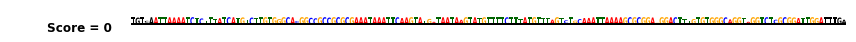

Pattern 1 (PWM & One-hot Sample)


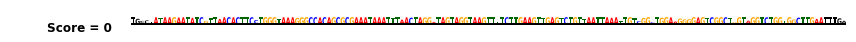

Pattern 2 (PWM & One-hot Sample)


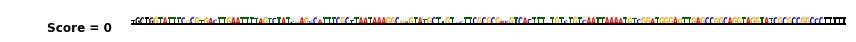

Pattern 3 (PWM & One-hot Sample)


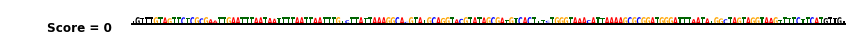

Pattern 4 (PWM & One-hot Sample)


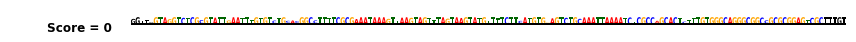

Epoch 2/20
Data index (train) = [21659 19075 30200 ... 38465 31457 32623]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.7191352
- Entropy Train Loss = 0.00026677627
- Discriminator Train Loss (real) = 0.69141287
- Discriminator Train Loss (fake) = 0.6764776
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 2:
- Generator Valid Loss = 0.68833184
- Entropy Valid Loss = 0.00013937289
- Discriminator Valid Loss (real) = 0.68966067
- Discriminator Valid Loss (fake) = 0.6981904
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.023953063
- Discriminator Valid Score (fake) = 0.04542089
- Discriminator Correct % = 29.02
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


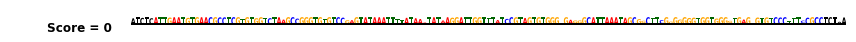

Pattern 1 (PWM & One-hot Sample)


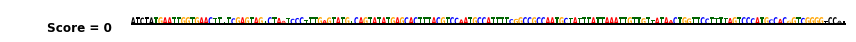

Pattern 2 (PWM & One-hot Sample)


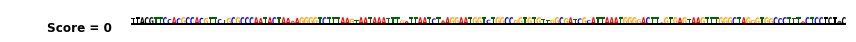

Pattern 3 (PWM & One-hot Sample)


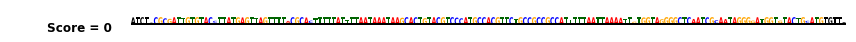

Pattern 4 (PWM & One-hot Sample)


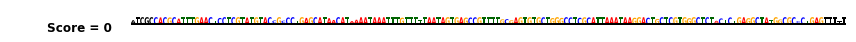

Epoch 3/20
Data index (train) = [20660 44732 27668 ... 19607 10073 23840]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.7011959
- Entropy Train Loss = 6.644235e-05
- Discriminator Train Loss (real) = 0.69275314
- Discriminator Train Loss (fake) = 0.6883449
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 3:
- Generator Valid Loss = 0.67074573
- Entropy Valid Loss = 0.000101977545
- Discriminator Valid Loss (real) = 0.66600204
- Discriminator Valid Loss (fake) = 0.7161043
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.0604442
- Discriminator Valid Score (fake) = 0.03907382
- Discriminator Correct % = 84.86
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


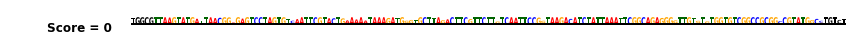

Pattern 1 (PWM & One-hot Sample)


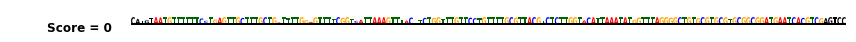

Pattern 2 (PWM & One-hot Sample)


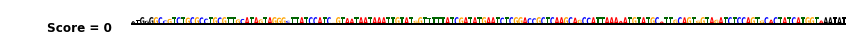

Pattern 3 (PWM & One-hot Sample)


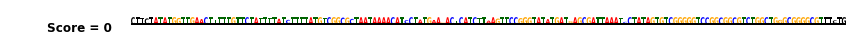

Pattern 4 (PWM & One-hot Sample)


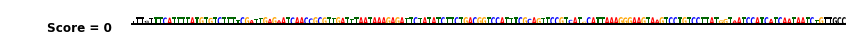

Epoch 4/20
Data index (train) = [35067 44857 38858 ... 12064 16708 30090]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.6963247
- Entropy Train Loss = 1.8035129e-05
- Discriminator Train Loss (real) = 0.6929841
- Discriminator Train Loss (fake) = 0.6914788
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 4:
- Generator Valid Loss = 0.67381495
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.67467725
- Discriminator Valid Loss (fake) = 0.712871
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.039727073
- Discriminator Valid Score (fake) = 0.04991936
- Discriminator Correct % = 24.27
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


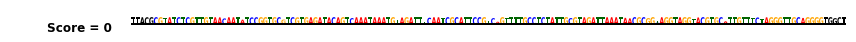

Pattern 1 (PWM & One-hot Sample)


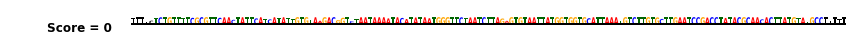

Pattern 2 (PWM & One-hot Sample)


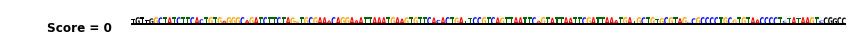

Pattern 3 (PWM & One-hot Sample)


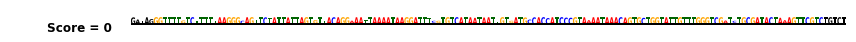

Pattern 4 (PWM & One-hot Sample)


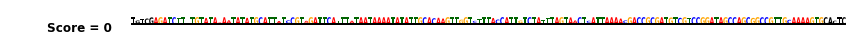

Epoch 5/20
Data index (train) = [35224 24267 16796 ... 12937 30439  1286]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 335s 67ms/step
- Generator Train Loss = 0.69508594
- Entropy Train Loss = 5.7052284e-06
- Discriminator Train Loss (real) = 0.69301033
- Discriminator Train Loss (fake) = 0.6921347
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 5:
- Generator Valid Loss = 0.7113385
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.7110074
- Discriminator Valid Loss (fake) = 0.6752847
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = -0.034121893
- Discriminator Valid Score (fake) = -0.03327187
- Discriminator Correct % = 45.78
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


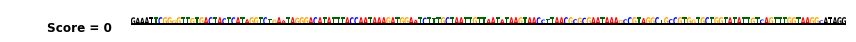

Pattern 1 (PWM & One-hot Sample)


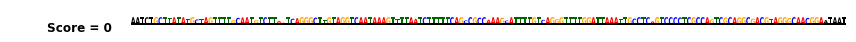

Pattern 2 (PWM & One-hot Sample)


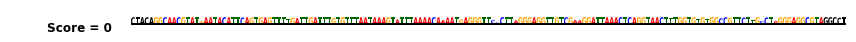

Pattern 3 (PWM & One-hot Sample)


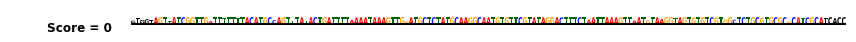

Pattern 4 (PWM & One-hot Sample)


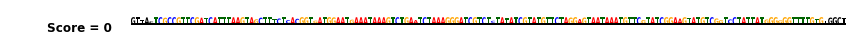

Epoch 6/20
Data index (train) = [ 8651  1344 11468 ... 26826 40116  5910]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.6947126
- Entropy Train Loss = 5.3608715e-06
- Discriminator Train Loss (real) = 0.69304043
- Discriminator Train Loss (fake) = 0.69227713
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 6:
- Generator Valid Loss = 0.6920556
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.69134605
- Discriminator Valid Loss (fake) = 0.6942582
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.0060109226
- Discriminator Valid Score (fake) = 0.0076300194
- Discriminator Correct % = 44.81
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


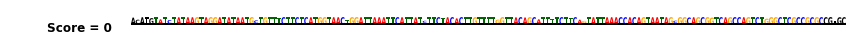

Pattern 1 (PWM & One-hot Sample)


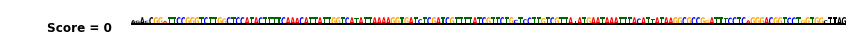

Pattern 2 (PWM & One-hot Sample)


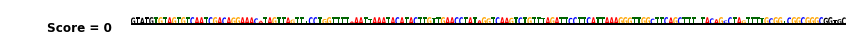

Pattern 3 (PWM & One-hot Sample)


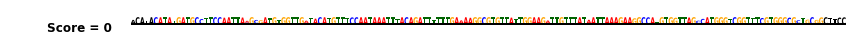

Pattern 4 (PWM & One-hot Sample)


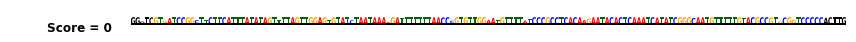

Epoch 7/20
Data index (train) = [35562 23809 40143 ... 40910  8960  5838]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.6946731
- Entropy Train Loss = 1.5005857e-06
- Discriminator Train Loss (real) = 0.69309133
- Discriminator Train Loss (fake) = 0.69229096
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 7:
- Generator Valid Loss = 0.7070815
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.70598763
- Discriminator Valid Loss (fake) = 0.6794275
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = -0.02344981
- Discriminator Valid Score (fake) = -0.026271421
- Discriminator Correct % = 61.44
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


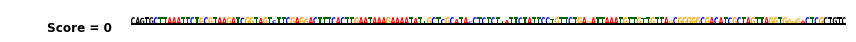

Pattern 1 (PWM & One-hot Sample)


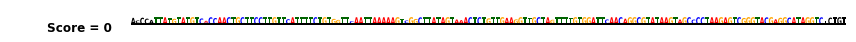

Pattern 2 (PWM & One-hot Sample)


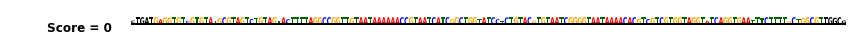

Pattern 3 (PWM & One-hot Sample)


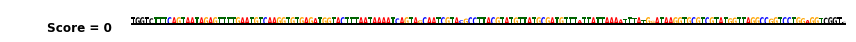

Pattern 4 (PWM & One-hot Sample)


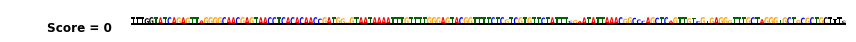

Epoch 8/20
Data index (train) = [16956 19426 25494 ... 16097 33512 39160]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.69462276
- Entropy Train Loss = 2.7902425e-07
- Discriminator Train Loss (real) = 0.69304925
- Discriminator Train Loss (fake) = 0.6922835
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 8:
- Generator Valid Loss = 0.69887024
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.6969296
- Discriminator Valid Loss (fake) = 0.68746144
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = -0.005378211
- Discriminator Valid Score (fake) = -0.014124359
- Discriminator Correct % = 78.08
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


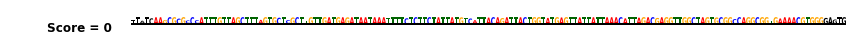

Pattern 1 (PWM & One-hot Sample)


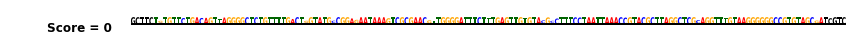

Pattern 2 (PWM & One-hot Sample)


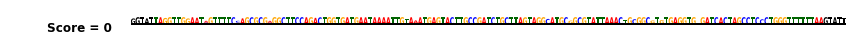

Pattern 3 (PWM & One-hot Sample)


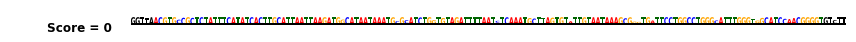

Pattern 4 (PWM & One-hot Sample)


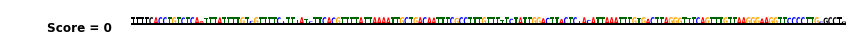

Epoch 9/20
Data index (train) = [ 2855  4731 19028 ... 29984  4864  1525]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 339s 68ms/step
- Generator Train Loss = 0.6944992
- Entropy Train Loss = 9.894699e-07
- Discriminator Train Loss (real) = 0.6930818
- Discriminator Train Loss (fake) = 0.6923462
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 9:
- Generator Valid Loss = 0.6914617
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.689038
- Discriminator Valid Loss (fake) = 0.69484043
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.009918445
- Discriminator Valid Score (fake) = -0.0035651366
- Discriminator Correct % = 91.31
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


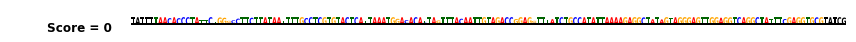

Pattern 1 (PWM & One-hot Sample)


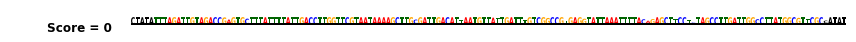

Pattern 2 (PWM & One-hot Sample)


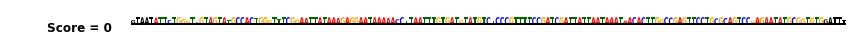

Pattern 3 (PWM & One-hot Sample)


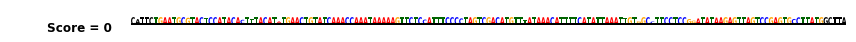

Pattern 4 (PWM & One-hot Sample)


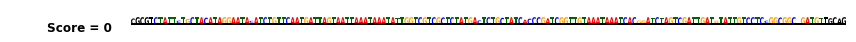

Epoch 10/20
Data index (train) = [28870 39744  2350 ... 43429 28542 16792]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 339s 68ms/step
- Generator Train Loss = 0.6944378
- Entropy Train Loss = 3.1375885e-07
- Discriminator Train Loss (real) = 0.69309324
- Discriminator Train Loss (fake) = 0.6923738
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 10:
- Generator Valid Loss = 0.6927492
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.69223964
- Discriminator Valid Loss (fake) = 0.69355464
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.0032269314
- Discriminator Valid Score (fake) = -0.0064806454
- Discriminator Correct % = 86.93
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


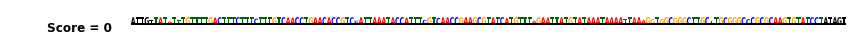

Pattern 1 (PWM & One-hot Sample)


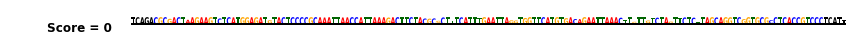

Pattern 2 (PWM & One-hot Sample)


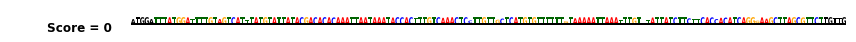

Pattern 3 (PWM & One-hot Sample)


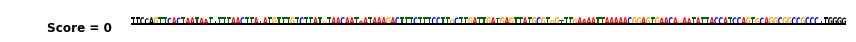

Pattern 4 (PWM & One-hot Sample)


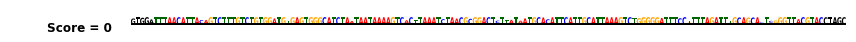

Epoch 11/20
Data index (train) = [ 9568 11965 27557 ... 42919  1055 13696]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 339s 68ms/step
- Generator Train Loss = 0.6945474
- Entropy Train Loss = 8.178532e-07
- Discriminator Train Loss (real) = 0.6930624
- Discriminator Train Loss (fake) = 0.6922421
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 11:
- Generator Valid Loss = 0.6774778
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.6770866
- Discriminator Valid Loss (fake) = 0.70908314
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.033886652
- Discriminator Valid Score (fake) = 0.022388307
- Discriminator Correct % = 85.59
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


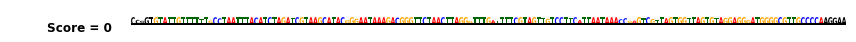

Pattern 1 (PWM & One-hot Sample)


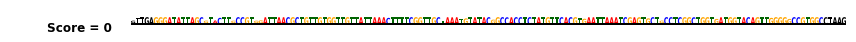

Pattern 2 (PWM & One-hot Sample)


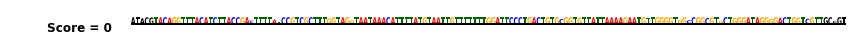

Pattern 3 (PWM & One-hot Sample)


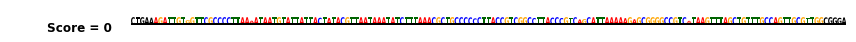

Pattern 4 (PWM & One-hot Sample)


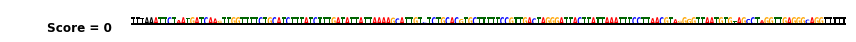

Epoch 12/20
Data index (train) = [14525  4269 32619 ... 13324 26345 37727]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 341s 68ms/step
- Generator Train Loss = 0.6945585
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.6930845
- Discriminator Train Loss (fake) = 0.6922603
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 12:
- Generator Valid Loss = 0.69203377
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.6921279
- Discriminator Valid Loss (fake) = 0.69425774
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.0037037823
- Discriminator Valid Score (fake) = -0.012493474
- Discriminator Correct % = 92.53
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


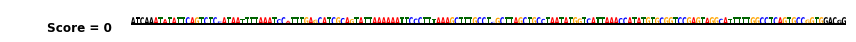

Pattern 1 (PWM & One-hot Sample)


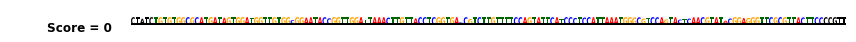

Pattern 2 (PWM & One-hot Sample)


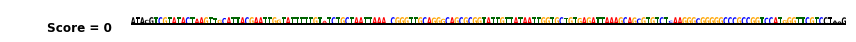

Pattern 3 (PWM & One-hot Sample)


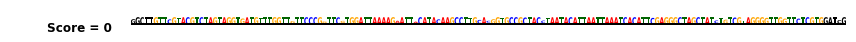

Pattern 4 (PWM & One-hot Sample)


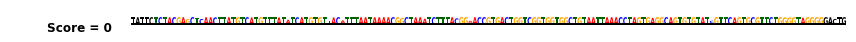

Epoch 13/20
Data index (train) = [20324 35480 32883 ... 26561 41445 25458]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 341s 68ms/step
- Generator Train Loss = 0.6945206
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.6930689
- Discriminator Train Loss (fake) = 0.69224185
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 13:
- Generator Valid Loss = 0.71107876
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.708878
- Discriminator Valid Loss (fake) = 0.67553896
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = -0.029526833
- Discriminator Valid Score (fake) = -0.046987284
- Discriminator Correct % = 94.03
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


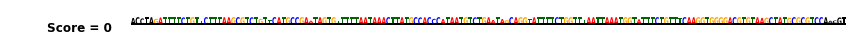

Pattern 1 (PWM & One-hot Sample)


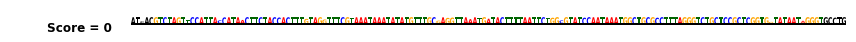

Pattern 2 (PWM & One-hot Sample)


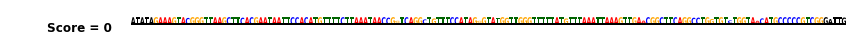

Pattern 3 (PWM & One-hot Sample)


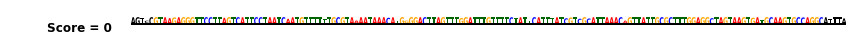

Pattern 4 (PWM & One-hot Sample)


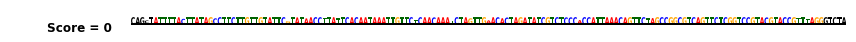

Epoch 14/20
Data index (train) = [ 3987 35663   645 ... 34170 15588 12354]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.69462824
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.6930795
- Discriminator Train Loss (fake) = 0.6921533
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 14:
- Generator Valid Loss = 0.697075
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.6964343
- Discriminator Valid Loss (fake) = 0.68924654
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = -0.005171556
- Discriminator Valid Score (fake) = -0.020499729
- Discriminator Correct % = 92.78
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


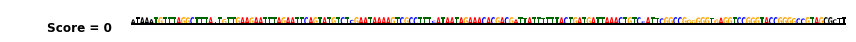

Pattern 1 (PWM & One-hot Sample)


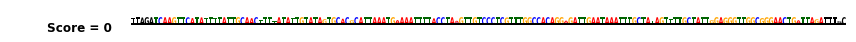

Pattern 2 (PWM & One-hot Sample)


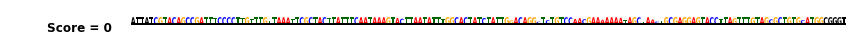

Pattern 3 (PWM & One-hot Sample)


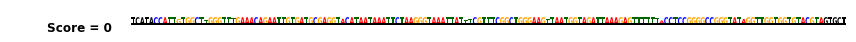

Pattern 4 (PWM & One-hot Sample)


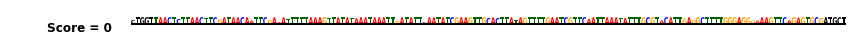

Epoch 15/20
Data index (train) = [28837  9634   307 ...  4166 24804 28957]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.6946184
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.6930599
- Discriminator Train Loss (fake) = 0.69217
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 15:
- Generator Valid Loss = 0.69472927
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.69395983
- Discriminator Valid Loss (fake) = 0.69158256
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.0004675787
- Discriminator Valid Score (fake) = -0.0113548655
- Discriminator Correct % = 82.02
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


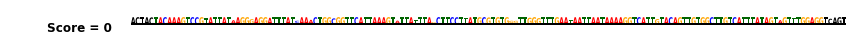

Pattern 1 (PWM & One-hot Sample)


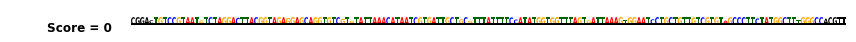

Pattern 2 (PWM & One-hot Sample)


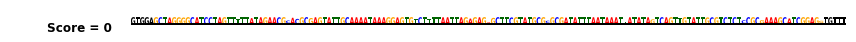

Pattern 3 (PWM & One-hot Sample)


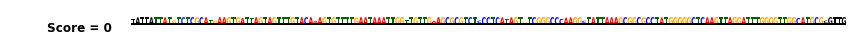

Pattern 4 (PWM & One-hot Sample)


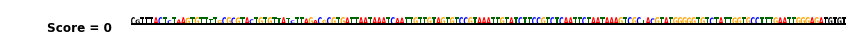

Epoch 16/20
Data index (train) = [42248  3956 36990 ... 12431 30621  4141]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.6947684
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.6930761
- Discriminator Train Loss (fake) = 0.6920308
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 16:
- Generator Valid Loss = 0.6914202
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.6911565
- Discriminator Valid Loss (fake) = 0.6948928
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.0062388815
- Discriminator Valid Score (fake) = -0.0033093547
- Discriminator Correct % = 74.76
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


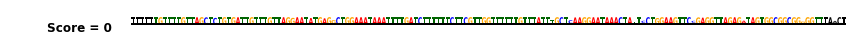

Pattern 1 (PWM & One-hot Sample)


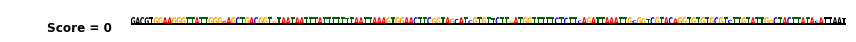

Pattern 2 (PWM & One-hot Sample)


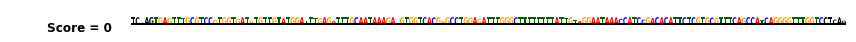

Pattern 3 (PWM & One-hot Sample)


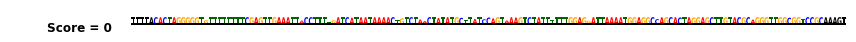

Pattern 4 (PWM & One-hot Sample)


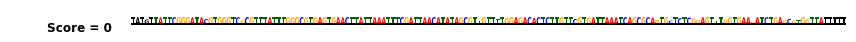

Epoch 17/20
Data index (train) = [20850 30317  6775 ... 11950 28672 43137]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.69467765
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.6930701
- Discriminator Train Loss (fake) = 0.6920644
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 17:
- Generator Valid Loss = 0.70940846
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.7073863
- Discriminator Valid Loss (fake) = 0.67716545
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = -0.026217539
- Discriminator Valid Score (fake) = -0.043012355
- Discriminator Correct % = 90.26
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


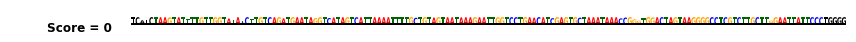

Pattern 1 (PWM & One-hot Sample)


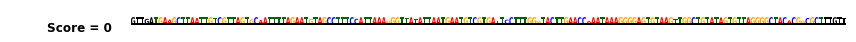

Pattern 2 (PWM & One-hot Sample)


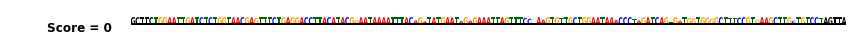

Pattern 3 (PWM & One-hot Sample)


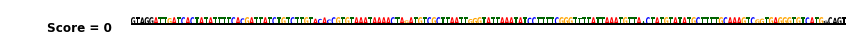

Pattern 4 (PWM & One-hot Sample)


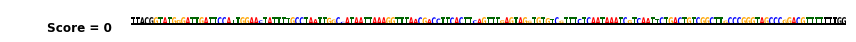

Epoch 18/20
Data index (train) = [ 9090 38751   579 ... 15530 38799 40935]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.6946833
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.69308186
- Discriminator Train Loss (fake) = 0.69206405
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 18:
- Generator Valid Loss = 0.7014888
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.70005023
- Discriminator Valid Loss (fake) = 0.6848968
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = -0.011688551
- Discriminator Valid Score (fake) = -0.031635012
- Discriminator Correct % = 95.01
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


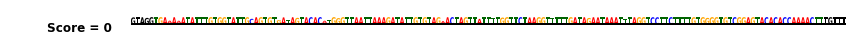

Pattern 1 (PWM & One-hot Sample)


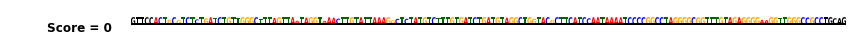

Pattern 2 (PWM & One-hot Sample)


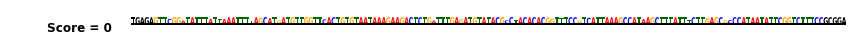

Pattern 3 (PWM & One-hot Sample)


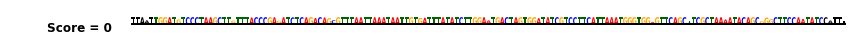

Pattern 4 (PWM & One-hot Sample)


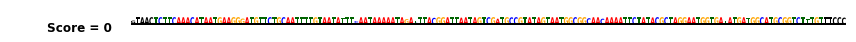

Epoch 19/20
Data index (train) = [16370 28035 31794 ... 41321  9864 42204]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 336s 67ms/step
- Generator Train Loss = 0.69483066
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.69308025
- Discriminator Train Loss (fake) = 0.6919406
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 19:
- Generator Valid Loss = 0.6847143
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.6831627
- Discriminator Valid Loss (fake) = 0.7016727
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.02242598
- Discriminator Valid Score (fake) = 0.005550588
- Discriminator Correct % = 87.87
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


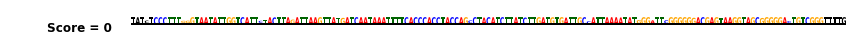

Pattern 1 (PWM & One-hot Sample)


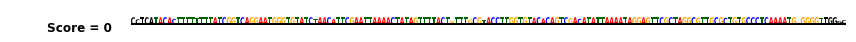

Pattern 2 (PWM & One-hot Sample)


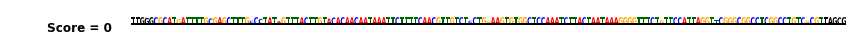

Pattern 3 (PWM & One-hot Sample)


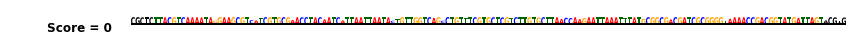

Pattern 4 (PWM & One-hot Sample)


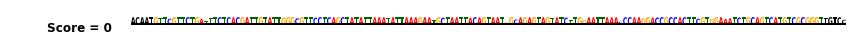

Epoch 20/20
Data index (train) = [22771  3009 28252 ... 21789 32565 15641]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 338s 68ms/step
- Generator Train Loss = 0.69467044
- Entropy Train Loss = 0.0
- Discriminator Train Loss (real) = 0.69305307
- Discriminator Train Loss (fake) = 0.69209117
- Discriminator Train Loss (grad) = 0.0
Testing for epoch 20:
- Generator Valid Loss = 0.69089437
- Entropy Valid Loss = 0.0
- Discriminator Valid Loss (real) = 0.68999237
- Discriminator Valid Loss (fake) = 0.69543254
- Discriminator Valid Loss (grad) = 0.0
- Discriminator Valid Score (real) = 0.008570637
- Discriminator Valid Score (fake) = -0.0033898961
- Discriminator Correct % = 77.48
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


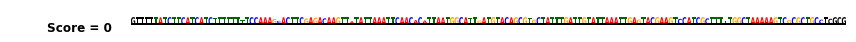

Pattern 1 (PWM & One-hot Sample)


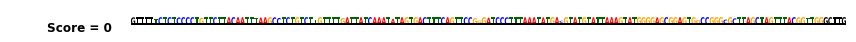

Pattern 2 (PWM & One-hot Sample)


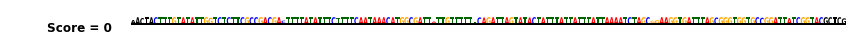

Pattern 3 (PWM & One-hot Sample)


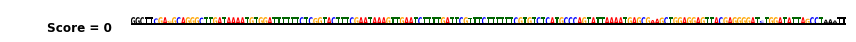

Pattern 4 (PWM & One-hot Sample)


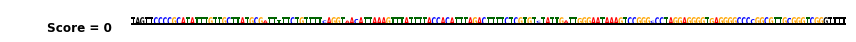

In [21]:

from_epoch = 1

n_epochs = 20

n_iters = 5000

validation_frequency = 1000

training_ratio = 1

verbose = True
verbose_n_pwms, verbose_n_samples = 5, 0

#Specify entropy anneal function
entropy_anneal_func = lambda epoch: 1.0

max_n_valid_batches = 200

epoch_train_history = defaultdict(list)
epoch_valid_history = defaultdict(list)
valid_history = defaultdict(list)

for epoch in range(from_epoch, n_epochs + 1) :
    print('Epoch {}/{}'.format(epoch, n_epochs))
    print("Data index (train) = " + str(data_gens['train'].indexes))

    progress_bar = Progbar(target=n_iters)

    K.set_value(entropy_anneal_coeff, entropy_anneal_func(epoch - 1))
    
    print("Entropy anneal coeff. = " + str(round(K.get_value(entropy_anneal_coeff), 3)))
    
    gen_train_losses = []
    ent_train_losses = []
    
    disc_real_train_losses = []
    disc_fake_train_losses = []
    disc_gp_train_losses = []
    
    for index in range(1, n_iters + 1) :
        sequence_batch = data_gens['train'][(index - 1) % len(data_gens['train'])][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.train_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        disc_real_train_losses.append(real_l)
        disc_fake_train_losses.append(fake_l)
        disc_gp_train_losses.append(gp_l)
        
        if index % training_ratio == 0 :
            
            class_batch = np.zeros((batch_size, 1), dtype=np.int)
            seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
            
            _, gen_l, ent_l = discriminator_model_fake_data.train_on_batch(
                [class_batch, seed_batch],
                [dummy_data_target, dummy_data_target]
            )
            
            gen_train_losses.append(gen_l)
            ent_train_losses.append(ent_l)
        
        if index % validation_frequency == 0 :
            evaluate_gan(data_gens['valid'], generator_model, discriminator_model, valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
        
        progress_bar.update(index)
    
    gen_train_loss = np.mean(np.array(gen_train_losses), axis=0)
    ent_train_loss = np.mean(np.array(ent_train_losses), axis=0)
    
    disc_real_train_loss = np.mean(np.array(disc_real_train_losses), axis=0)
    disc_fake_train_loss = np.mean(np.array(disc_fake_train_losses), axis=0)
    disc_gp_train_loss = np.mean(np.array(disc_gp_train_losses), axis=0)
    
    epoch_train_history['generator_loss'].append(gen_train_loss)
    epoch_train_history['entropy_loss'].append(ent_train_loss)
    epoch_train_history['discriminator_real_loss'].append(disc_real_train_loss)
    epoch_train_history['discriminator_fake_loss'].append(disc_fake_train_loss)
    epoch_train_history['discriminator_gp_loss'].append(disc_gp_train_loss)
    
    print("- Generator Train Loss = " + str(gen_train_loss))
    print("- Entropy Train Loss = " + str(ent_train_loss))
    print("- Discriminator Train Loss (real) = " + str(disc_real_train_loss))
    print("- Discriminator Train Loss (fake) = " + str(disc_fake_train_loss))
    print("- Discriminator Train Loss (grad) = " + str(disc_gp_train_loss))
    
    
    print('Testing for epoch {}:'.format(epoch))
    
    evaluate_gan_loss(data_gens['valid'], discriminator_model_fake_data, discriminator_model_real_data, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Generator Valid Loss = " + str(epoch_valid_history['generator_loss'][-1]))
    print("- Entropy Valid Loss = " + str(epoch_valid_history['entropy_loss'][-1]))
    print("- Discriminator Valid Loss (real) = " + str(epoch_valid_history['discriminator_real_loss'][-1]))
    print("- Discriminator Valid Loss (fake) = " + str(epoch_valid_history['discriminator_fake_loss'][-1]))
    print("- Discriminator Valid Loss (grad) = " + str(epoch_valid_history['discriminator_gp_loss'][-1]))
    
    evaluate_gan(data_gens['valid'], generator_model, discriminator_model, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Discriminator Valid Score (real) = " + str(epoch_valid_history['discriminator_real_score'][-1]))
    print("- Discriminator Valid Score (fake) = " + str(epoch_valid_history['discriminator_fake_score'][-1]))
    print("- Discriminator Correct % = " + str(round(epoch_valid_history['discriminator_accuracy'][-1] * 100, 2)))

    if verbose :
    
        print("- Fake Patterns (Randomly Generated) -")
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))
        
        _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch(x=[class_batch, seed_batch])

        for plot_i in range(min(verbose_n_pwms, batch_size)) :
            print('Pattern ' + str(plot_i) + ' (PWM & One-hot Sample)')
            plot_gan_logo(fake_pwm_batch[plot_i, 0, :, :], 0, sequence_template=sequence_templates[0], figsize=(12, 0.5), width_ratios=[1, 7], logo_height=1.0, plot_start=125-50, plot_end=125-50+157)
            
    data_gens['train'].on_epoch_end()


--- Training Losses ---

(Generator Losses)


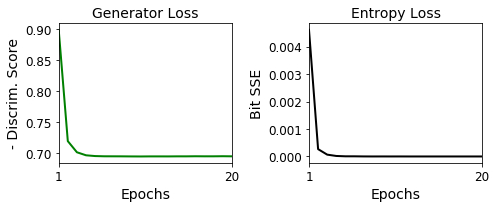

(Discriminator Losses)


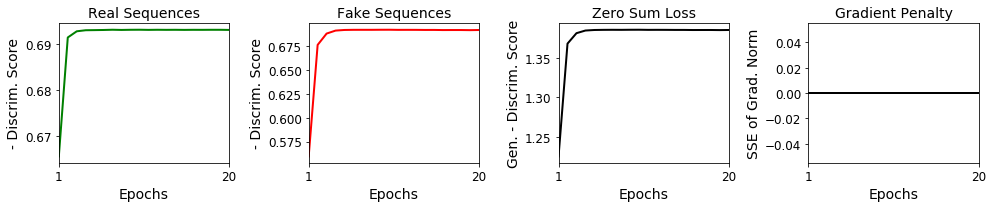

--- Validation Losses ---

(Generator Losses)


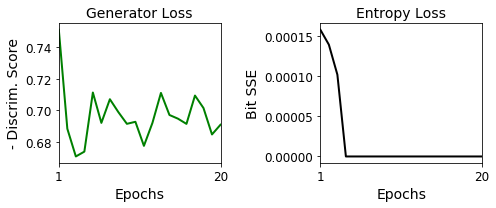

(Discriminator Losses)


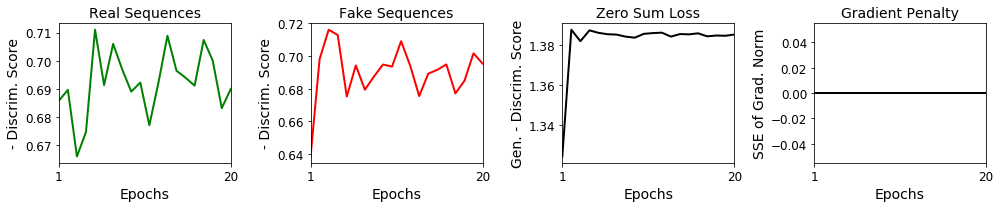

In [26]:

for eval_str, eval_history in [('Training', epoch_train_history), ('Validation', epoch_valid_history)] :

    print("--- " + eval_str + " Losses ---")
    print("")
    
    print("(Generator Losses)")
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5 * 2, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['generator_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Generator Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['entropy_loss'], linewidth=2, color='black')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Bit SSE", fontsize=14)
    plt.title("Entropy Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()
    
    print("(Discriminator Losses)")

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_real_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Real Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_fake_loss'], linewidth=2, color='red')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Fake Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax3.plot(np.arange(1, n_epochs + 1), np.ravel(eval_history['discriminator_fake_loss']) + np.ravel(eval_history['discriminator_real_loss']), linewidth=2, color='black')

    plt.sca(ax3)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Gen. - Discrim. Score", fontsize=14)
    plt.title("Zero Sum Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)
    
    ax4.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_gp_loss'], linewidth=2, color='black')

    plt.sca(ax4)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("SSE of Grad. Norm", fontsize=14)
    plt.title("Gradient Penalty", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()


Validation Metrics (Frequent)


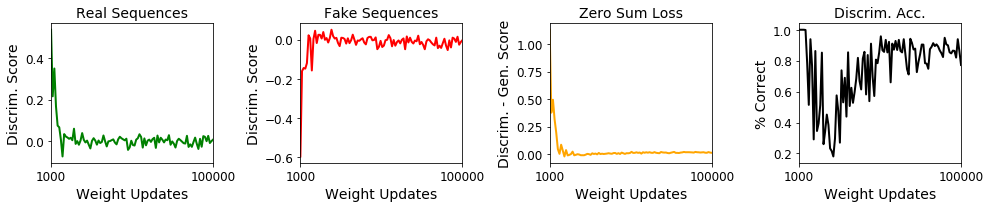

In [27]:
print("Validation Metrics (Frequent)")

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

t = np.arange(1, len(valid_history['discriminator_real_score']) + 1) * validation_frequency

ax1.plot(t, valid_history['discriminator_real_score'], linewidth=2, color='green')

plt.sca(ax1)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Real Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(t, valid_history['discriminator_fake_score'], linewidth=2, color='red')

plt.sca(ax2)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Fake Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(t, np.ravel(valid_history['discriminator_real_score']) - np.ravel(valid_history['discriminator_fake_score']), linewidth=2, color='orange')

plt.sca(ax3)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. - Gen. Score", fontsize=14)
plt.title("Zero Sum Loss", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax4.plot(t, valid_history['discriminator_accuracy'], linewidth=2, color='black')

plt.sca(ax4)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("% Correct", fontsize=14)
plt.title("Discrim. Acc.", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

In [24]:
#Save model weights and evaluation metrics
save_dir = 'saved_models'

task_suffix = '_simple'

gen_suffix = '_gen_new_resnet'
disc_suffix = '_disc_new_resnet'

train_suffix = '_sngan_multisample_instancenorm_normal'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_discriminator.h5'
model_path = os.path.join(save_dir, model_name)
discriminator_model.save(model_path)
print('Saved trained model at %s ' % model_path)


metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_train_history.pickle'
pickle.dump(epoch_train_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_valid_history.pickle'
pickle.dump(epoch_valid_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_valid_history.pickle'
pickle.dump(valid_history, open(metric_name, 'wb'))

print('Stored metrics.')

Saved trained model at saved_models/gan_simple_gen_new_resnet_disc_new_resnet_sngan_multisample_instancenorm_normal_generator.h5 
Saved trained model at saved_models/gan_simple_gen_new_resnet_disc_new_resnet_sngan_multisample_instancenorm_normal_discriminator.h5 
Stored metrics.


- Fake Sequences (Randomly Generated) -


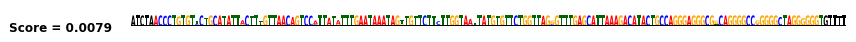

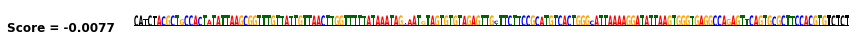

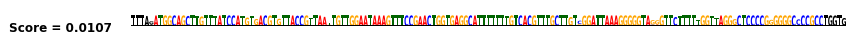

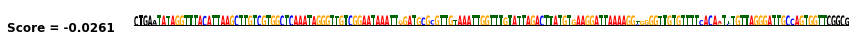

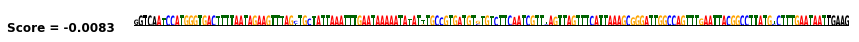

- Real Sequences (Randomly Sampled from Test Set) -


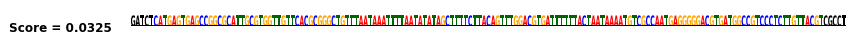

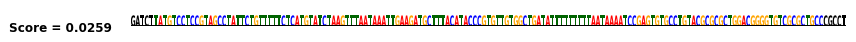

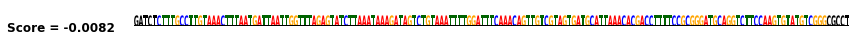

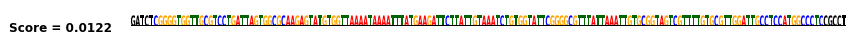

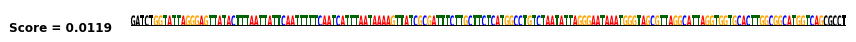

In [28]:
#Visualize a few fake and real sequence patterns

real_scores = []
real_sequences = []
fake_scores = []
fake_pwms = []
fake_sequences = []

for test_index in range(len(data_gens['test'])) :
    real_sequence_batch = data_gens['test'][test_index][0][0][:, 0, :, :, :]
    real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])

    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.normal(loc=0., scale=1., size=(batch_size, 100))

    _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
    fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])

    real_scores.append(real_score_batch)
    real_sequences.append(real_sequence_batch)
    fake_scores.append(fake_score_batch)
    fake_pwms.append(fake_pwm_batch)
    fake_sequences.append(fake_sequence_batch)

real_scores = np.concatenate(real_scores, axis=0)
real_sequences = np.concatenate(real_sequences, axis=0)
fake_scores = np.concatenate(fake_scores, axis=0)
fake_pwms = np.concatenate(fake_pwms, axis=0)
fake_sequences = np.concatenate(fake_sequences, axis=0)


print("- Fake Sequences (Randomly Generated) -")

for plot_i in range(5) :
    plot_gan_logo(fake_pwms[plot_i, 0, :, :], fake_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=125-50, plot_end=125-50+157)

print("- Real Sequences (Randomly Sampled from Test Set) -")

for plot_i in range(5) :
    plot_gan_logo(real_sequences[plot_i, 0, :, :], real_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=125-50, plot_end=125-50+157)
